In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Custom State

Up until now, we have seen simple reading and writing to state variables, like so:

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

def is_b_even(obj):
    return obj['b']%2==0


In [ ]:
from stringdale import Define,V,E,Condition

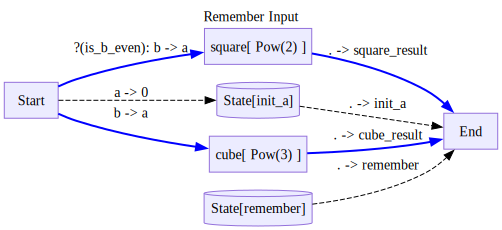

In [ ]:
with Define('Remember Input',type='decision') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

    E('Start->State/init_a(0=a)')
    V('End',inputs=['State/init_a(init_a=.)'])
    V('End',inputs=['State/remember(remember=.)'])
D.draw()

In [ ]:
d=D()
d.state.remember = 100
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output


{'square_result': 4, 'init_a': 1, 'remember': 100}

However, sometimes we would like to read and write state in a more customized way,
for example:

* Appending to a list or getting the last item from it
* Fetching the next item from a queue
* reading/writing from/to a database

Naively, this requires as to complicate our diagrams with additional nodes and helper functions that obscure the business logic of our diagram. 

To remedy this, stringdale allows passing custom state objects to be used.

First, let us understand what is going on under the hood:

* stringdale can accept as State any [Pydantic](https://docs.pydantic.dev/latest/) Model.
* By default, we supply every stringdale diagram with `BaseModelExtra` which we will see bellow.
* If we want to be able to serialize the diagram state, we need to make sure our Model is json serializable.

In [ ]:
from stringdale import BaseModelExtra
import inspect


As you can see, `BaseModelExtra` is a pydantic model that allows setting and getting arbitrary attributes.

In [ ]:
print(inspect.getsource(BaseModelExtra))

class BaseModelExtra(BaseModel):
    model_config = ConfigDict(extra='allow')



Before calling `run`, we can modify the `state` attribute however we like.
This includes running a diagram that has stopped during a breakpoint before.

Let us see several examples of custom states:

## TLDR

In [ ]:
from pydantic import BaseModel, ConfigDict, computed_field
from typing import Annotated

In [ ]:
# a custom state is any basemodel
class CustomState(BaseModel):
    # we can allow arbitrary attributes by setting extra='allow'
    # this is useful for defining on the fly state keys with normal behavior
    model_config = ConfigDict(extra='allow')

    # we can define normal attributes that will be part of the serialized state
    history:list[int] = list()
    
    # we can define private attributes that will not be part of the serialized state
    # to be used internally by other methods
    _hidden_attribute:str = 'hidden'

    # we can define computed fields that will be computed on access
    # these can be read, but not written to
    @computed_field
    def last_message(self)->int:
        if len(self.history) == 0:
            return 0
        return self.history[-1]

    # if we want to use the default getter for an object, but use a custom setter
    # we can annotate the attribute with the setter function
    annotated_list: Annotated[list[int],list.append] = list()

    # we can write custom getter methods that only take self, that will be called when reading from
    # state/first_message
    def first_message(self)->int:
        if len(self.history) == 0:
            return 0
        return self.history[0]

    # we can write custom setter methods that only take self, and the value to set
    # and will be called when writing to state/add_message
    def add_message(self,value):
        self.history.append(value)

    # we can also define pythonic properties via the @property decorator
    @property
    def hidden(self):
        return self._hidden_attribute
    @hidden.setter
    def hidden(self,value):
        self._hidden_attribute = value
    
    
    

## Saving history of a node to a list

In [ ]:
def add_1(a:int)->int:
    return a+1

def is_mod_3(a:int)->bool:
    return a%3==0


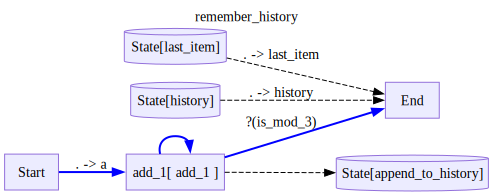

In [ ]:
class CustomState(BaseModel):
    # note that without the extra='allow' we would not be able to set any other state attributes
    history:list[int] = list()

    def append_to_history(self,value:int):
        self.history.append(value)
    
    def last_item(self)->int:
        return self.history[-1]
    
with Define('remember_history',type='decision',state=CustomState()) as D:
    V('add_1',add_1,
        inputs=['Start(a=.)'],
        outputs=[
            'State/append_to_history',
            ('End',is_mod_3),
            'add_1'
            ])
    V('End',inputs=[
        'State/last_item(last_item=.)',
        'State/history(history=.)'
        ])

D.draw()

In [ ]:
d = D()
for trace in d.run(0):
    trace.pprint(skip_passthrough=True)
d.output

{0: 3, 'last_item': 3, 'history': [1, 2, 3]}

## Example - React Agent

In [ ]:
from stringdale.chat import Chat
from pydantic import BaseModel
from typing import Literal,Optional,Any
from stringdale.tools import wikipedia_search,run_python_code
from pprint import pprint


Let us define a thinking agent and an tool calling agent

In [ ]:
react_system_prompt = [{'role':'system','content':"""
Answer the following questions as best you can.
Here is an example of the format of the answer:
Question: the input question you must answer
Thought: you should always think about what to do
Tool Name: the name of the tool you will use
Tool Input: the input to the tool
Observation: the result of the tool
This thought - tool name - tool input - observation can repeat N times
Final Answer: the final answer to the original input question
Each time you are prompter either provide a thought that you need to use a tool or provide a final answer.
the tool name, input and observation will be provided to you in the next message.

Example:
user:
Question: what is the year five years from now?
assistant:
Thought: I need to compute the current year
Tool Name: wikipedia_search
Tool Input: {query: 'what is the current year'}
Observation: 2024
Thought: I need to add 5 to the current year
Tool Name: run_python_code
Tool Input: {code: 'import datetime; result = datetime.datetime.now().year + 5',output_expression='result'}
Observation: 2029
Final Answer: 2029
"""}]


class Thought(BaseModel):
    type: Literal['thought','final_answer']
    text: str

react_thought_step = Chat(model='gpt-4o-mini',
    output_schema=Thought,
    )
react_thought_step



Chat(model='gpt-4o-mini', output_schema=Thought, seed=42)

In [ ]:
await react_thought_step(messages=react_system_prompt+[{'role':'user','content':'who is obama?'}])

{'role': 'assistant',
 'content': Thought(type='thought', text='I need to gather information about who Obama is.'),
 'meta': {'input_tokens': 405, 'output_tokens': 24}}

In [ ]:
tools = {
    'wikipedia_search':wikipedia_search,
    'run_python_code':run_python_code,
}

react_tool_step = Chat(model='gpt-4o-mini',
    messages= [
        {'role':'system','content':'choose an appropriate tool to use to answer the following:'},
        {'role':'user','content':'{{thought}}'}],
    tools=tools,
    call_function=True
    )
await react_tool_step(thought='what is the capital of france?')


{'role': 'assistant',
 'content': {'name': 'wikipedia_search',
  'input': {'q': 'capital of France'},
  'output': "This is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.\n\n\n== Chronology ==\nTournai (before 486), current-day Belgium\nSoissons (486–936)\nLaon (936–987)\nParis (987–1419), the residence of the Kings of France, although they were consecrated at Reims.\nOrléans (1108), one of the few consecrations of a French monarch to occur outside of Reims occurred at Orléans, when Louis VI the Fat was consecrated in Orléans Cathedral by Daimbert, Archbishop of Sens; from 13 December 1560 to 31 January 1561, the French States-General also met in the city.\nTroyes (1419–1422), for a short time during the Hundred Years' War, the city was the seat of the royal government.\nBourges (1422–1444), Charles VII was forced to flee from Paris.\nTours (1444–1527), Louis XI made the Château de Plessis-lez-Tours his residence.\nParis (1

In [ ]:
def react_cot_format(thought,tool_name,input,output):
    return {
        'role':'assistant',
        'content':f"""Thought: {thought}
Tool Name: {tool_name}
Tool Input: {input}
Observation: {output}"""
    }

def format_final_answer(final_answer):
    return {
        'role':'assistant',
        'content': final_answer
    }

is_final_answer= Condition('final_answer','(0=content.type)',name='is_final_answer')

Now let us create a custom state that tracks the history.


Since appending to a list is so simple, we can use the setter annotation to avoid implementing `append_to_history`

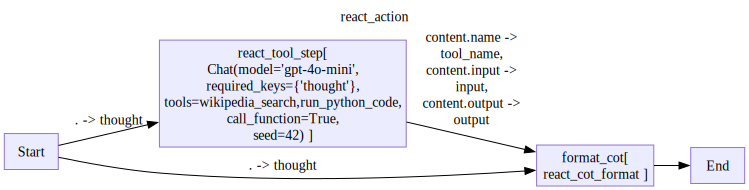

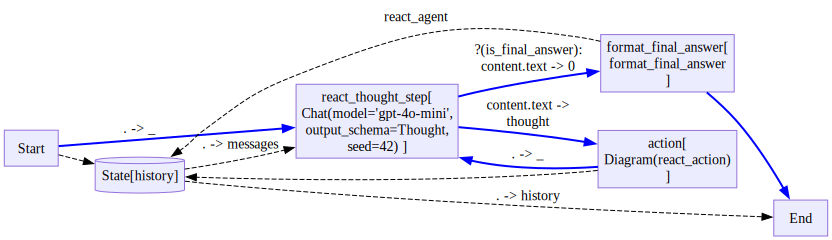

In [ ]:
class CustomState(BaseModel):
    # note that without the extra='allow' we would not be able to set any other state attributes
    history:Annotated[list[Any],list.append] = list()

with Define('react_action',type='flow') as ReactAction:
    V('react_tool_step',react_tool_step,
        inputs=['Start(thought=.)'],
    )
    V('format_cot',react_cot_format,
        inputs=[
            'Start(thought=.)',
            'react_tool_step(tool_name=content.name,input=content.input,output=content.output)',
        ],
        outputs=['End']
    )

ReactAction.draw()
    
with Define('react_agent',type='decision',state=CustomState()) as ReactAgent:
    V('Start',outputs=['state/history'])
    V('react_thought_step',react_thought_step,
        inputs=['Start(_)','State/history(messages=.)'],
        outputs=[
            ('format_final_answer(0=content.text)',is_final_answer),
            ('action(thought=content.text)',),
            ])
    V('action',ReactAction,
        outputs=[
            'State/history',
            'react_thought_step(_)'
            ])

    V('format_final_answer',format_final_answer,
        outputs=[
            'State/history',
            'End'
            ])
    V('End',inputs=[
        'State/history(history=.)'
        ])
ReactAgent.draw()

In [ ]:
d=ReactAgent()
d.state.history = react_system_prompt

user_input = {'role':'user','content':"Question: what is obamas age to the power of 2?"}

for trace in d.run(user_input):
    pass
print(d.output[0])

{'role': 'assistant', 'content': "Obama's age to the power of 2 is 4096."}


In [ ]:
for msg in d.output['history']:
    print(f"{msg['role']}:")
    print(msg['content'][:2000])
    if len(msg['content']) > 2000:
        print('...')
    print('='*80)

system:

Answer the following questions as best you can.
Here is an example of the format of the answer:
Question: the input question you must answer
Thought: you should always think about what to do
Tool Name: the name of the tool you will use
Tool Input: the input to the tool
Observation: the result of the tool
This thought - tool name - tool input - observation can repeat N times
Final Answer: the final answer to the original input question
Each time you are prompter either provide a thought that you need to use a tool or provide a final answer.
the tool name, input and observation will be provided to you in the next message.

Example:
user:
Question: what is the year five years from now?
assistant:
Thought: I need to compute the current year
Tool Name: wikipedia_search
Tool Input: {query: 'what is the current year'}
Observation: 2024
Thought: I need to add 5 to the current year
Tool Name: run_python_code
Tool Input: {code: 'import datetime; result = datetime.datetime.now().year + 5

## Example - Collecting User Info to a DataBase.

Let us see a slightly more sophisticated version of the collecting user info workflow we saw in the decision diagram tutorial.

For this demo we will use a small utility for creating a shared in-memory [sqlite](https://www.sqlite.org/) db and connecting to it via [sqlalchemy](https://www.sqlalchemy.org/).

We will also use [SQLModel](https://sqlmodel.tiangolo.com/) to sync our database schema with the output schema we will request our LLM to parse from text.

In [ ]:
from stringdale.db import temp_sql_db
from sqlmodel import SQLModel, Session, select, Field

In [ ]:
engine = temp_sql_db()

Let us make our user data object

In [ ]:
#| hide
# used for restarting the db
SQLModel.metadata.clear()

In [ ]:
class User(SQLModel, table=True,extend_existing=True):
    id: int = Field(default=None, primary_key=True)
    name: Optional[str] = Field(default=None)
    age: Optional[int] = Field(default=None)
    email: Optional[str] = Field(default=None)

# Loads the schema of all SQLModel subclasses into the db
SQLModel.metadata.create_all(engine)

Let us recall our previous get user data workflow:

In [ ]:
ask_missing_data = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant asks the user for missing information.
        Do not ask for keys if they are not a part of the missing keys
        Ask the user for the following missing keys:
        {{missing_keys}}
        '''}])

format_new_info = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that gets user data and makes sure it is complete.
        If you are not sure that you were given the relevant information, put None in the relevant field.
        Fill part of the missing keys based on the user data.
        If the user didnt provide info an a given missing key, leave it empty
        
        {% if current_info %}
        The information we have so far is:
        {{current_info}}
        {% endif %}
        The missing keys are:
        {{missing_keys}}
        '''},
        {'role':'user','content':'{{input}}'},
        
    ],
    output_schema=User)

class MissingKeys():
    def __init__(self,keys):
        self.keys = keys

    def get_missing_keys(self,obj):
        return [key for key in self.keys if getattr(obj,key,None) is None]

    def has_missing_keys(self,obj):
        return len(self.get_missing_keys(obj)) > 0

missing = MissingKeys(['name','age'])

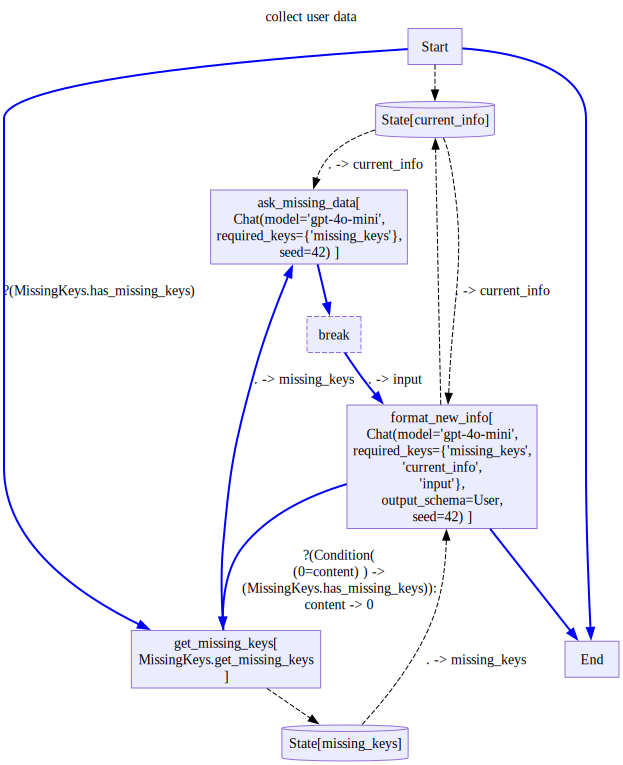

In [ ]:
with Define('collect user data',type='decision') as UserQA:
    V('Start',
        outputs=[
            ('get_missing_keys',missing.has_missing_keys),
            ('End',),
            ('state/current_info',)
        ])

    V('get_missing_keys',missing.get_missing_keys,
        outputs=[
            'ask_missing_data(missing_keys)',
            'state/missing_keys'

        ])

    V('ask_missing_data',ask_missing_data,
        inputs=['state/current_info(current_info)'],
        outputs=['break']    )

    V('break',is_break=True,outputs=['format_new_info(input)'])

    
    V('format_new_info',format_new_info,
        inputs=[
            'state/current_info(current_info)',
            'state/missing_keys(missing_keys=.)'
        ],
        outputs=[
            ('get_missing_keys(0=content)',Condition(missing.has_missing_keys,'(0=content)')),
            'End',
            'state/current_info'
        ])

UserQA.draw(direction='TB')


Now, let us create our custom state, which will have methods for getting and setting users in our db.

In [ ]:
class UserDBState(BaseModel):
    model_config = ConfigDict(extra='allow')
    engine: Optional[Any] = None
    user_id: Optional[int] = None
    # this is a private attribute that will not be serialized
    # used to cache the user object to avoid extra db calls
    _user:Optional[User]=None


    def get_user(self):
        user_id = self.user_id
        if not self._user is None:
            return self._user
        with Session(self.engine) as session:
            user = session.exec(select(User).where(User.id == user_id)).first()
            self._user = user
        if self._user is None:
            self._user = User(id=user_id)
        return self._user

    def add_user(self,user_data):
        self._user = user_data
        with Session(self.engine) as session:
            session.merge(user_data)
            session.commit()
        

Our new DB workflow will look very similar to the old one, but instead of reading and writing to current info, we will use the `get_user` and `add_user` methods of our state object.

We will also read the user info into start, so we can skip the workflow if we have all the info we need.

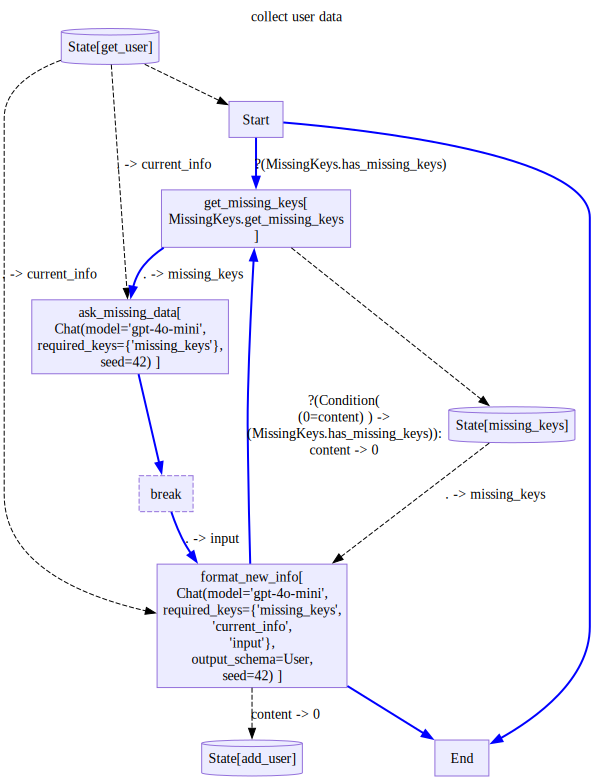

In [ ]:
with Define('collect user data',type='decision',state=UserDBState()) as UserQADB:
    V('Start',
        inputs=['state/get_user(0=.)'],
        outputs=[
            ('get_missing_keys',missing.has_missing_keys),
            ('End',),
        ])

    V('get_missing_keys',missing.get_missing_keys,
        outputs=[
            'ask_missing_data(missing_keys)',
            'state/missing_keys'

        ])

    V('ask_missing_data',ask_missing_data,
        inputs=['state/get_user(current_info)'],
        outputs=['break']    )

    V('break',is_break=True,outputs=['format_new_info(input)'])

    
    V('format_new_info',format_new_info,
        inputs=[
            'state/get_user(current_info)',
            'state/missing_keys(missing_keys=.)'
        ],
        outputs=[
            ('get_missing_keys(0=content)',Condition(missing.has_missing_keys,'(0=content)')),
            'End',
            'state/add_user(0=content)'
        ])

UserQADB.draw(direction='TB')


In [ ]:
d = UserQADB()
# we can change the attributes of the UserDBState object
d.state.user_id = 1
d.state.engine = engine
# or just override the state object completely
d.state = UserDBState(user_id=1,engine=engine)
d.state.get_user()

User(id=1, name=None, age=None, email=None)

In [ ]:
d.run_all(input=None)

{'role': 'assistant',
 'content': 'Could you please provide your name and age?',
 'meta': {'input_tokens': 50, 'output_tokens': 9}}

In [ ]:
d.run_all('alice, 25yo')

{'role': 'assistant',
 'content': User(id=1, name='alice', age=25, email=None),
 'meta': {'input_tokens': 356, 'output_tokens': 29}}

Since we have saved the result to a DB, if we try to run this diagram again for the same user, we will skip straight to the end, since all user data will be retrieved from the DB.

In [ ]:
d = UserQADB()
d.state = UserDBState(user_id=1,engine=engine)
d.state.get_user()

User(email=None, name='alice', id=1, age=25)

In [ ]:
d.run_all(input=None)

User(email=None, name='alice', id=1, age=25)